# Testen des PV Modells
Zunächst wird die Funktionalität des PV Modells getestet. Dazu werden die Modell Ausgänge mit dem Modell von renewables ninjas verglichen

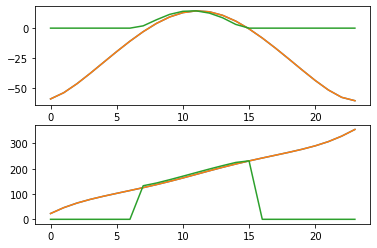

In [3]:
import test
from datetime import datetime, timedelta
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pv_aggregation import PVPlantOpti

# Test Inputs
time = [datetime(2015, 1, 1, hour,0 ,0) for hour in range(0,24)]
Latitude = 52.5170365
Longitude = 13.3888599


# results
res1 = PVPlantOpti.CalcSolarAngle(pd.DatetimeIndex(time), pd.Series([Longitude,]*2), pd.Series([Latitude,]*2))
res2 = test.sun_angles(pd.DatetimeIndex(time), (Latitude, Longitude))

fig, axs = plt.subplots(2,1)
axs[0].plot( np.rad2deg(res1["sun_alt"].values))
axs[0].plot( np.rad2deg(res2["sun_alt"].values))
axs[1].plot( np.rad2deg(res1["sun_azimuth"].values))
axs[1].plot( np.rad2deg(res2["sun_azimuth"].values))

## Laden der Wetterdaten pro NUTS2 Zone

In [4]:
import sqlite3
WEATHER_DB = 'C:\\Users\\studt\\source\\repos\\program\\winMoz\\winMoz\\Data\\Files\\SQLITE\\mzdb_data.db'
start = datetime(2015,1,1)
end = datetime(2020,1,1)

cnx = sqlite3.connect(WEATHER_DB)
sqlstring = 'select * from data_weather where utc_timestamp >= "' + start.strftime('%Y-%m-%dT%H:%M:%SZ') + '" and utc_timestamp <= "' + end.strftime('%Y-%m-%dT%H:%M:%SZ') + '"'
dfWeather = pd.read_sql_query(sqlstring,cnx )

# Zeilen für Deutschland ausfiltern
de_cols = ["utc_timestamp"] + [col for col in dfWeather.columns if "DE" in col and "wind" not in col]
dfWeather = dfWeather.loc[:, de_cols]

# DateTimeIndex setzen
dfWeather["utc_timestamp"] = pd.to_datetime(dfWeather["utc_timestamp"])
dfWeather.set_index("utc_timestamp", inplace = True)
dfWeather = dfWeather.tz_localize(None)
dfWeather = dfWeather.loc[~dfWeather.index.duplicated()]

# nuts2 split
nuts2list  = list(set([col.split("_",1)[0] for col in dfWeather.columns]))
dfs = dict([(nuts, dfWeather.filter(like = nuts+'_')) for nuts in nuts2list])
for df1 in dfs:
    dfs[df1].columns = dfs[df1].columns.str.strip(df1+"_")
    dfs[df1].rename(mapper= {"temperature": "T_env", "radiation_direct_horizontal": "RadDirHor", "radiation_diffuse_horizontal": "RadDiffHor"}, axis = 1, inplace= True)

dfWeather = pd.concat(dfs, axis = 1)

C:\Program Files (x86)\Microsoft Visual Studio\Shared\Python37_64\lib\site-packages\pandas\core\frame.py:4449: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


## Laden der Produktionsdaten
Die Daten zeigen die Gesamtproduktion durch PV Anllagen in Deutschland. Allerdings sind sie auf 10000 kW installierter Leistung normiert. Danach werden die Daten zusammen mit der Produktion geplottet um zu prüfen ob die Zeitstempel übereinander liegen.

C:\Users\studt\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in double_scalars
  del sys.path[0]


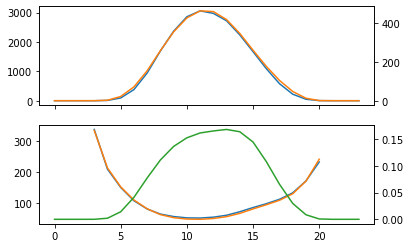

In [8]:
from datetime import datetime
dateparse = lambda x,y: datetime.strptime(x + y, '%d.%m.%Y%H:%M')
dfProduction = pd.read_csv('C:\\Users\\studt\\source\\repos\\mozubi_tools\\_Data\\PV_Aggregation\\20210607 nomierte Zeitreiehen.csv', sep = ";", decimal= ",", skiprows=5, parse_dates= {"TimeStamp": [0,1]}, date_parser= dateparse)
dfProduction.loc[:,"TimeStamp"] = dfProduction.loc[:, "TimeStamp"] -timedelta(hours = 1)
dfProduction.set_index("TimeStamp", inplace = True)
dfProduction.drop(["Photovoltaik[MWh]", "Relative Produktion"], inplace = True, axis = 1)
dfProduction.rename(mapper = {"Normierte Produktion KW": "PV_Ante"}, axis = 1, inplace = True)
fig, axs = plt.subplots(2,1, sharex = True)
ax_1 = axs[0].twinx()
ax_2 = axs[1].twinx()
axs[0].plot(dfProduction.groupby(dfProduction.index.hour).mean())
ax_1.plot(dfWeather["DE"][["RadDirHor", "RadDiffHor"]].sum(axis = 1).groupby(dfWeather.index.hour).mean(), color = 'C1')
cv = lambda x: np.std(x, ddof=1) / np.mean(x) * 100 
axs[1].plot(dfProduction.groupby(dfProduction.index.hour).aggregate(cv))
axs[1].plot(dfWeather["DE"][["RadDirHor", "RadDiffHor"]].sum(axis = 1).groupby(dfWeather.index.hour).aggregate(cv), color = 'C1')
ax_2.plot((dfProduction / 10000).groupby(dfProduction.index.hour).std(), color = 'C2')

## Test des Modells in Abhängigkeit von West, Süd, Ost Ausrichtung

Der oberer Plot zeigt die durschnittliche Produktion pro Monat der drei PV Anlagen. Der untere Plot zeigt die durschnittliche Produktion im Tagesverlauf. 

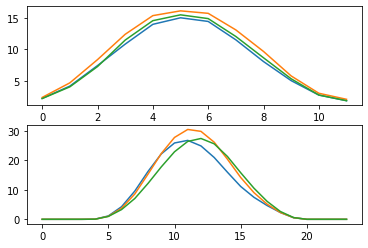

In [13]:
pvPlant = pd.DataFrame({"Latitude": [52.5170365,]*3,
            "Longitude": [13.3888599,]*3,
            "ModuleAzimute": [90,180,270],
            "Load_Factor": [0.8,]*3,
            "PowerMW": [100,]*3,
            "ModuleAngle": [20, 20, 20]})
df = pd.DataFrame(PVPlantOpti.getPVfromSolarOnePlantAndNUTS(pvPlant, dfWeather["DE"] ), index = dfWeather.index)
fig, ax = plt.subplots(2,1)
ax[0].plot(range(0, 12), df.groupby(df.index.month).mean())
ax[1].plot(range(0, 24), df.groupby(df.index.hour).mean())

## Test des Modells in Abhängigkeit des Sonnenwinkels

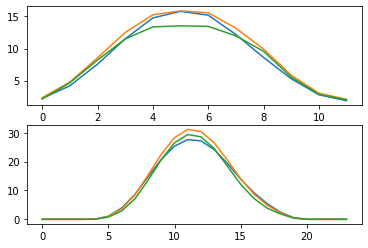

In [14]:
pvPlant = pd.DataFrame({"Latitude": [52.5170365,]*3,
            "Longitude": [13.3888599,]*3,
            "ModuleAzimute": [180,180,180],
            "Load_Factor": [0.8,]*3,
            "PowerMW": [100,]*3,
            "ModuleAngle": [0, 30, 60]})
df = pd.DataFrame(PVPlantOpti.getPVfromSolarOnePlantAndNUTS(pvPlant, dfWeather["DE"] ), index = dfWeather.index)
fig, ax = plt.subplots(2,1)
ax[0].plot(range(0, 12), df.groupby(df.index.month).mean())
ax[1].plot(range(0, 24), df.groupby(df.index.hour).mean())

## Die Optimierungsfunktionen
Die erste FUnktion optimiert mit variabler installierter Gesamtleistung. Die Verhältnisse bleiben allerdings gleich. Es wir zusättzlich der Modulneigungswinkel optimiert. 
Die zweite Funktion nimmt einen festen Neigungswinkel an und optimiert die installierte Leistung aller Krafwerke unabhängig ihrer tatsächlichen Verhältnisse.

In [22]:
def optimization(x, production, pvPlants, weather, angles):
    np.seterr(all = "ignore")
    pvPlants["PowerMW"] = pvPlants["PowerMWRelative"] * x[0]
    pvPlants["ModuleAngle"] = x[1:]
    out = production - np.nan_to_num(PVPlantOpti.getForAllNuts(pvPlants, weather, angles).astype(np.float64))
    return out

In [25]:
def optimization2(x, production, pvPlants, weather, angles):
    np.seterr(all = "ignore")
    pvPlants["PowerMW"] = x
    pvPlants["ModuleAngle"] = 20
    out =  np.nan_to_num(PVPlantOpti.getForAllNuts(pvPlants, weather, angles).astype(np.float64)) - production
    return out

## Funktionen für PV Anlagen
Die Funktionen laden die aggregierten PV Anlagen des Marktstammdatenregisters.
Die erste Funktion gibt die PV Anlagen pro NUTS2 Zone in jeweils Ost, Süd, West Ausrichtung. 
Die zweite Funktion teilt die Anlagen in Ost, Süd, West und 0-20, 20-40, 40-60 Grad Neigung auf. 
Die dritte Funktion teilt die Anlagen pro NUTS2 Zone in Ost, Süd, West und 0-20, 20-40, 40-60 Grad Neigung auf.

In [26]:
def get_PVPlants1():    
    df = pd.read_csv("C:\\Users\\studt\\source\\repos\\mozubi_tools\\_Data\\PV_Aggregation\\20210602 PV Cluster NUts2.csv", skiprows=2, sep = ";", usecols=[1,2,3,4,5], names = ["NUTS2", "Winkel",  "Ost_MW", "Sued_MW", "West_MW"])
    dfLocations = pd.read_csv("C:\\Users\\studt\\source\\repos\\mozubi_tools\\_Data\\PV_Aggregation\\Locations.csv", decimal = ',')
    dfLocations.drop(["NUTS1", "NUTS3", "Municipality", "Postcode"], axis = 1, inplace = True)
    dfLocations = dfLocations.groupby("NUTS2").mean()
    df.drop("Winkel", axis = 1, inplace= True)
    df = df.groupby("NUTS2").sum()
    totalsum = df.loc[:,["Ost_MW", "Sued_MW", "West_MW"]].sum().sum()
    df.loc[:,["Ost_MW", "Sued_MW", "West_MW"]] = df.loc[:,["Ost_MW", "Sued_MW", "West_MW"]] / totalsum
    df = df.loc[df["Ost_MW"]+ df["Sued_MW"] + df["West_MW"] > 0.01]
    df = df.join(dfLocations)   

    df.reset_index(inplace = True)
    pvPlants = pd.DataFrame(columns= ["PowerMWRelative", "Latitude", "Longitude", "ModuleAzimute", "NUTS2"])
    for id in df.index:
        pvPlants.loc[id * 3, ["PowerMWRelative", "Latitude", "Longitude", "NUTS2"]] = df.loc[id, ["Ost_MW", "Latitude", "Longitude", "NUTS2"]].values
        pvPlants.loc[id * 3 + 1, ["PowerMWRelative", "Latitude", "Longitude", "NUTS2"]] = df.loc[id, ["Sued_MW", "Latitude", "Longitude", "NUTS2"]].values
        pvPlants.loc[id * 3 + 2, ["PowerMWRelative", "Latitude", "Longitude", "NUTS2"]] = df.loc[id, ["West_MW", "Latitude", "Longitude","NUTS2"]].values
        pvPlants.loc[id * 3: (id+1)*3, "ModuleAzimute"] = [90.0, 180.0, 270.0]
    pvPlants["Load_Factor"] = 0.8
    pvPlants["ModuleAngle"] = 20.0
    return pvPlants


In [16]:
def get_PVPlants2():    
    df = pd.read_csv("C:\\Users\\studt\\source\\repos\\mozubi_tools\\_Data\\PV_Aggregation\\20210602 PV Cluster NUts2.csv", skiprows=2, sep = ";", usecols=[1,2,3,4,5], names = ["NUTS2", "Winkel",  "Ost_MW", "Sued_MW", "West_MW"])
    dfLocations = pd.read_csv("C:\\Users\\studt\\source\\repos\\mozubi_tools\\_Data\\PV_Aggregation\\Locations.csv", decimal = ',')
    dfLocations.drop(["NUTS1", "NUTS3", "Municipality", "Postcode"], axis = 1, inplace = True)
    dfLocations = dfLocations.groupby("NUTS2").mean().mean()
    df = df.groupby("Winkel").sum()
    totalsum = df.loc[:,["Ost_MW", "Sued_MW", "West_MW"]].sum().sum()
    df.loc[:,["Ost_MW", "Sued_MW", "West_MW"]] = df.loc[:,["Ost_MW", "Sued_MW", "West_MW"]] / totalsum
    df = df.loc[df["Ost_MW"]+ df["Sued_MW"] + df["West_MW"] > 0.01] 
    df.reset_index(inplace = True)
    pvPlants = pd.DataFrame(columns= ["PowerMWRelative", "Latitude", "Longitude", "ModuleAzimute", "ModuleAngle", "NUTS2"])
    for id in df.index:
        pvPlants.loc[id * 3, ["PowerMWRelative"]] = df.loc[id, ["Ost_MW"]].values
        pvPlants.loc[id * 3 + 1, ["PowerMWRelative"]] = df.loc[id, ["Sued_MW"]].values
        pvPlants.loc[id * 3 + 2, ["PowerMWRelative"]] = df.loc[id, ["West_MW"]].values
        pvPlants.loc[id * 3: (id+1)*3, "ModuleAzimute"] = [90.0, 180.0, 270.0]
    pvPlants["Load_Factor"] = 0.8
    pvPlants["ModuleAngle"] = [30,] * 3 + [50,] * 3 +  [10,] * 3 
    pvPlants["Latitude"] = dfLocations["Latitude"]
    pvPlants["Longitude"] = dfLocations["Longitude"]
    pvPlants["NUTS2"] = "DE"
    return pvPlants

In [9]:
def get_PVPlants3():    
    df = pd.read_csv("C:\\Users\\studt\\source\\repos\\mozubi_tools\\_Data\\PV_Aggregation\\20210602 PV Cluster NUts2.csv", skiprows=2, sep = ";", usecols=[1,2,3,4,5], names = ["NUTS2", "Winkel",  "Ost_MW", "Sued_MW", "West_MW"])
    dfLocations = pd.read_csv("C:\\Users\\studt\\source\\repos\\mozubi_tools\\_Data\\PV_Aggregation\\Locations.csv", decimal = ',')
    dfLocations.drop(["NUTS1", "NUTS3", "Municipality", "Postcode"], axis = 1, inplace = True)
    dfLocations = dfLocations.groupby("NUTS2").mean()
    df = df.groupby(["NUTS2", "Winkel"]).sum()
    totalsum = df.loc[:,["Ost_MW", "Sued_MW", "West_MW"]].sum().sum()
    df.loc[:,["Ost_MW", "Sued_MW", "West_MW"]] = df.loc[:,["Ost_MW", "Sued_MW", "West_MW"]] / totalsum
    df = df.loc[df["Ost_MW"]+ df["Sued_MW"] + df["West_MW"] > 0.01]
    df = df.join(dfLocations)   

    df.reset_index(inplace = True)
    pvPlants = pd.DataFrame(columns= ["PowerMWRelative", "Latitude", "Longitude", "ModuleAzimute", "NUTS2"])
    for id in df.index:
        pvPlants.loc[id * 3, ["PowerMWRelative", "Latitude", "Longitude", "NUTS2"]] = df.loc[id, ["Ost_MW", "Latitude", "Longitude", "NUTS2"]].values
        pvPlants.loc[id * 3 + 1, ["PowerMWRelative", "Latitude", "Longitude", "NUTS2"]] = df.loc[id, ["Sued_MW", "Latitude", "Longitude", "NUTS2"]].values
        pvPlants.loc[id * 3 + 2, ["PowerMWRelative", "Latitude", "Longitude", "NUTS2"]] = df.loc[id, ["West_MW", "Latitude", "Longitude","NUTS2"]].values
        pvPlants.loc[id * 3: (id+1)*3, "ModuleAzimute"] = [90.0, 180.0, 270.0]
        if df.loc[id, "Winkel"] == "20 - 40 Grad":
            pvPlants.loc[id*3:(id+1)*3, "ModuleAngle"] = 30.0
        elif df.loc[id, "Winkel"] == "< 20 Grad":
            pvPlants.loc[id*3:(id+1)*3, "ModuleAngle"] = 10.0
    pvPlants["Load_Factor"] = 0.8
    return pvPlants

## Matching der Wetter und Erzeugungsdaten
So bleiben nur vollständige Datensätze übrig.

In [20]:
dfWeather.dropna(inplace = True, how = "any", axis = 1)
dfProduction.dropna(inplace = True, how = "any", axis = 1)

idx, weatherIdx, productionIdx = dfWeather.index.join(dfProduction.index, how = "inner", return_indexers = True)

dfWeather = dfWeather.iloc[weatherIdx, :]
dfProduction = dfProduction.iloc[productionIdx, :]


angles = PVPlantOpti.CalcSolarAngle(dfWeather.index, pvPlants["Longitude"], pvPlants["Latitude"])

## Initialiserungsfunktion
Die Funktion gibt die Startwerte und Grenzen für den Optimierer basierend auf den gegebenen PV Plants.

In [17]:
def getInit(plants):
    x0 = list()
    lowerBounds = list()
    upperBounds = list()
    for vals in plants["ModuleAngle"]:
        if vals == 10:
            x0.append(10)
            lowerBounds.append(0)
            upperBounds.append(20)
        elif vals == 30:
            x0.append(30)
            lowerBounds.append(20)
            upperBounds.append(40)
        elif vals == 50:
            x0.append(50)
            lowerBounds.append(30)
            upperBounds.append(60)
        elif vals == 20:
            x0.append(30)
            lowerBounds.append(0)
            upperBounds.append(60)
    return x0, lowerBounds, upperBounds

## Optimierung 1
Aufteilung der Anlagen pro NUTS2 in Ost, Süd, West und Optimierung der Winkel zwischen 0-20, 20-40 und 40-60 Grad.

   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         6.1121e+09                                    1.23e+10    
       1              2         2.4351e+09      3.68e+09       4.18e+03       2.97e+09    
       2              3         1.7375e+09      6.98e+08       1.97e+03       6.54e+08    
       3              4         1.6340e+09      1.03e+08       8.46e+02       8.16e+07    
       4              5         1.5923e+09      4.17e+07       2.28e+02       3.11e+07    
       5              6         1.5877e+09      4.61e+06       6.19e+01       5.35e+06    
       6              7         1.5865e+09      1.20e+06       1.52e+01       4.44e+05    
       7              8         1.5864e+09      1.08e+05       1.58e+00       2.33e+04    
       8              9         1.5864e+09      1.48e+03       4.42e-02       3.54e+02    
       9             10         1.5864e+09      7.82e+00       7.11e-04       1.72e+00    

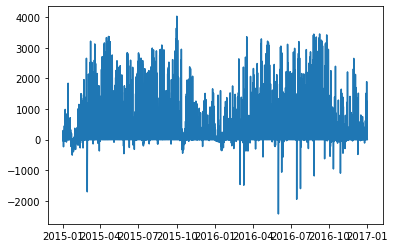

In [13]:

from scipy.optimize import least_squares
pvPlants = get_PVPlants3()
angles = PVPlantOpti.CalcSolarAngle(dfWeather.index, pvPlants["Longitude"], pvPlants["Latitude"])
x0 , lowerBounds, upperBounds = getInit(pvPlants)
x0 = [10000.0] + x0
lowerBounds = [0.0,] + lowerBounds
upperBounds = [20000.0] + upperBounds

plt.plot(optimization(x0, dfProduction["PV_Ante"], pvPlants, dfWeather, angles))

res = least_squares(optimization, x0,verbose=2, bounds = (lowerBounds, upperBounds), args = (dfProduction["PV_Ante"], pvPlants, dfWeather, angles) )

print(res)

## Optimierung 2
Aufteilung der Anlagen pro NUTS2 in Ost, Süd, West und Optimierung der Winkel zwischen 0-60 Grad.

   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         1.8791e+09                                    4.57e+09    
       1              2         1.5432e+09      3.36e+08       1.06e+03       1.51e+09    
       2              3         1.5100e+09      3.33e+07       3.65e+02       1.29e+08    
       3              4         1.4715e+09      3.84e+07       3.27e+02       1.98e+08    
       4              5         1.4558e+09      1.58e+07       1.87e+02       4.20e+07    
       5              6         1.4445e+09      1.13e+07       1.27e+02       6.87e+07    
       6              7         1.4262e+09      1.83e+07       2.35e+02       6.45e+07    
       7              8         1.4247e+09      1.58e+06       4.29e+01       3.35e+07    
       8              9         1.4238e+09      8.39e+05       1.86e+01       1.48e+07    
       9             10         1.4234e+09      4.28e+05       9.17e+00       4.19e+06    

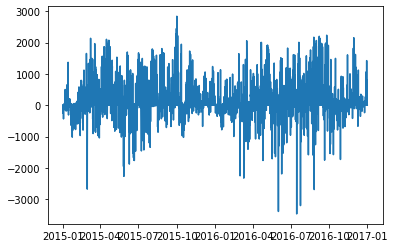

In [27]:
from scipy.optimize import least_squares
pvPlants = get_PVPlants1()
angles = PVPlantOpti.CalcSolarAngle(dfWeather.index, pvPlants["Longitude"], pvPlants["Latitude"])
x0 , lowerBounds, upperBounds = getInit(pvPlants)
x0 = [10000.0] + x0
lowerBounds = [0.0,] + lowerBounds
upperBounds = [20000.0] + upperBounds

plt.plot(optimization(x0, dfProduction["PV_Ante"], pvPlants, dfWeather, angles))

res = least_squares(optimization, x0,verbose=2, bounds = (lowerBounds, upperBounds), args = (dfProduction["PV_Ante"], pvPlants, dfWeather, angles) )

print(res)

## Optimierung 3
Aufteilung der Anlagen in Ost, Süd, West und Optimierung zwischen 0-20, 20-40, 40-60 Grad.

   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         1.9452e+09                                    3.22e+09    
       1              2         1.7503e+09      1.95e+08       5.06e+02       9.80e+08    
       2              3         1.7313e+09      1.90e+07       1.53e+02       6.37e+08    
       3              4         1.7219e+09      9.49e+06       1.09e+02       3.48e+08    
       4              5         1.7178e+09      4.09e+06       7.24e+01       1.19e+08    
       5              6         1.7157e+09      2.02e+06       4.93e+01       1.88e+07    
       6              7         1.7148e+09      9.90e+05       1.20e+01       2.40e+06    
       7              8         1.7147e+09      2.51e+04       6.63e-01       4.52e+04    
       8              9         1.7147e+09      3.07e+02       1.18e-02       4.86e+02    
       9             10         1.7147e+09      1.58e+00       1.26e-04       4.07e+00    

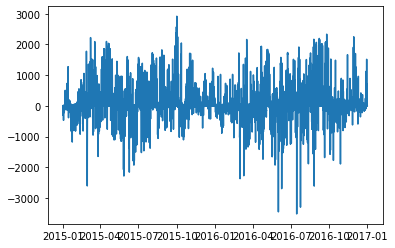

In [14]:

from scipy.optimize import least_squares
pvPlants = get_PVPlants2()
angles = PVPlantOpti.CalcSolarAngle(dfWeather.index, pvPlants["Longitude"], pvPlants["Latitude"])
x0 , lowerBounds, upperBounds = getInit(pvPlants)
x0 = [10000.0] + x0
lowerBounds = [0.0,] + lowerBounds
upperBounds = [20000.0] + upperBounds

plt.plot(optimization(x0, dfProduction["PV_Ante"], pvPlants, dfWeather, angles))

res = least_squares(optimization, x0,verbose=2, bounds = (lowerBounds, upperBounds), args = (dfProduction["PV_Ante"], pvPlants, dfWeather, angles) )

print(res.x)

## Optimierung 4
Aufteilung der Anlagen in Ost, Süd, West und Werte zwischen 0-20, 20-40, 40-60 Grad. Optimierung der installierten Leistung für die jeweilgen Anteile.


  PowerMWRelative   Latitude  Longitude ModuleAzimute  ModuleAngle NUTS2  \
0        0.043356  50.849872   9.629523          90.0           20    DE   
1        0.438381  50.849872   9.629523         180.0           20    DE   
2        0.061221  50.849872   9.629523         270.0           20    DE   
3        0.011847  50.849872   9.629523          90.0           20    DE   
4        0.071414  50.849872   9.629523         180.0           20    DE   
5        0.017974  50.849872   9.629523         270.0           20    DE   
6        0.065021  50.849872   9.629523          90.0           20    DE   
7        0.218868  50.849872   9.629523         180.0           20    DE   
8        0.071917  50.849872   9.629523         270.0           20    DE   

   Load_Factor      PowerMW  
0          0.8   433.561235  
1          0.8  4383.806124  
2          0.8   612.210562  
3          0.8   118.473656  
4          0.8   714.142291  
5          0.8   179.739278  
6          0.8   650.211918  

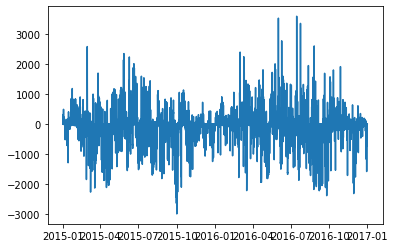

In [15]:

from scipy.optimize import least_squares

x0 = 10000.0 * pvPlants["PowerMWRelative"].values  
lowerBounds = [0.0,] *len(pvPlants)
upperBounds = [20000.0]* len(pvPlants)  

plt.plot(optimization2(x0, dfProduction["PV_Ante"], pvPlants, dfWeather, angles))

res = least_squares(optimization2, x0,verbose=2, bounds = (lowerBounds, upperBounds), args = (dfProduction["PV_Ante"], pvPlants, dfWeather, angles) )

print(res)

## Plot einer Anlage über alle Neigungswinkel zwischen 10 und 15 Uhr

                            0          1          2          3          4   \
utc_timestamp                                                                
2015-01-01 10:00:00  10.754111  10.815750  10.875880  10.934481  10.991533   
2015-01-01 11:00:00  11.493377  11.564382  11.633762  11.701497  11.767564   
2015-01-01 12:00:00  10.280812  10.340646  10.399023  10.455924  10.511332   
2015-01-01 13:00:00   7.115694   7.144285   7.171851   7.198380   7.223865   
2015-01-01 14:00:00   2.385821   2.390313   2.394414   2.398123   2.401439   

                            5          6          7          8          9   \
utc_timestamp                                                                
2015-01-01 10:00:00  11.047020  11.100921  11.153221  11.203903  11.252950   
2015-01-01 11:00:00  11.831941  11.894609  11.955548  12.014737  12.072158   
2015-01-01 12:00:00  10.565228  10.617595  10.668415  10.717673  10.765353   
2015-01-01 13:00:00   7.248296   7.271666   7.293966   7.315190

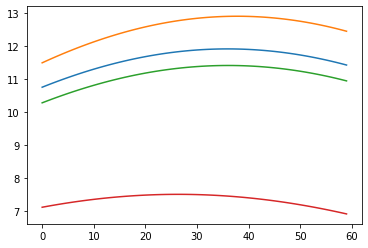

In [23]:
pvPlant = pd.DataFrame({"Latitude": [52.5170365,]*60,
            "Longitude": [13.3888599,]*60,
            "ModuleAzimute": [180,]*60,
            "Load_Factor": [0.8,]*60,
            "PowerMW": [100,]*60,
            "ModuleAngle": range(0,60)})
res = PVPlantOpti.getPVfromSolarOnePlantAndNUTS(pvPlant, dfWeather["DE"].iloc[10:15] )
print(res)
plt.plot(range(0,60),res.values[0])
plt.plot(range(0,60),res.values[1])
plt.plot(range(0,60),res.values[2])
plt.plot(range(0,60),res.values[3])

# Boxplot für Ergebnisse der Optimierung 2

402.8119771146914


{'whiskers': [<matplotlib.lines.Line2D at 0x20e91b05a08>,
 'caps': [<matplotlib.lines.Line2D at 0x20e91b357c8>,
 'boxes': [<matplotlib.lines.Line2D at 0x20e91b2cac8>],
 'medians': [<matplotlib.lines.Line2D at 0x20e91b2cf08>],
 'fliers': [<matplotlib.lines.Line2D at 0x20e91b35188>],
 'means': []}

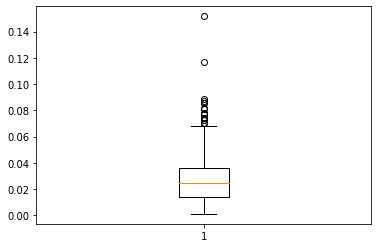

In [29]:

pvPlants = get_PVPlants1()
angles = PVPlantOpti.CalcSolarAngle(dfWeather.index, pvPlants["Longitude"], pvPlants["Latitude"])
x0  = [10000.0] + [20.0,]* len(pvPlants)  
resInit = optimization(x0, dfProduction["PV_Ante"], pvPlants, dfWeather, angles)

x1 = [1.23047102e+04, 5.58325127e-09, 6.00000000e+01, 6.00000000e+01, 1.89265452e-07, 6.00000000e+01, 6.00000000e+01, 2.77147978e-07, 6.00000000e+01, 6.00000000e+01, 6.86025585e-07, 6.00000000e+01, 6.00000000e+01, 2.46226043e-06, 6.00000000e+01, 6.00000000e+01, 6.00000000e+01, 6.00000000e+01, 6.00000000e+01, 6.00000000e+01, 6.00000000e+01, 6.00000000e+01, 6.00000000e+01, 6.00000000e+01, 6.00000000e+01, 6.00000000e+01, 6.00000000e+01, 6.00000000e+01, 4.24354069e-07, 6.00000000e+01, 6.00000000e+01, 6.00000000e+01, 6.00000000e+01, 6.00000000e+01, 1.33399860e-07, 6.00000000e+01, 6.00000000e+01, 8.42372208e-08, 6.00000000e+01, 6.00000000e+01, 9.99127844e-08, 6.00000000e+01, 6.00000000e+01, 6.00000000e+01, 6.00000000e+01, 6.00000000e+01, 7.13266662e-08, 6.00000000e+01, 6.00000000e+01, 6.00000000e+01, 6.00000000e+01, 6.00000000e+01, 1.81779355e-08, 6.00000000e+01, 6.00000000e+01, 4.88506750e-08, 6.00000000e+01, 6.00000000e+01, 7.67263351e-08, 6.00000000e+01, 6.00000000e+01, 2.76036374e-08, 6.00000000e+01, 6.00000000e+01, 3.44903303e-08, 6.00000000e+01, 6.00000000e+01, 3.76594951e-08, 6.00000000e+01, 6.00000000e+01, 1.63553202e-07, 6.00000000e+01, 6.00000000e+01, 7.05133235e-08, 6.00000000e+01, 6.00000000e+01, 6.00000000e+01, 6.00000000e+01, 6.00000000e+01, 4.56184311e-08, 6.00000000e+01, 6.00000000e+01, 6.00000000e+01, 6.00000000e+01, 6.00000000e+01, 6.00000000e+01, 6.00000000e+01, 6.00000000e+01, 6.00000000e+01, 6.00000000e+01, 6.00000000e+01, 6.00000000e+01, 6.00000000e+01, 6.00000000e+01, 6.00000000e+01, 6.00000000e+01, 6.00000000e+01, 6.00000000e+01, 6.00000000e+01, 6.00000000e+01]  
resOpti = optimization(x1, dfProduction["PV_Ante"], pvPlants, dfWeather, angles)
#plt.plot(resOpti.groupby(resOpti.index.hour).mean())
squaredErr = pd.Series( resOpti.values ** 2, index =resOpti.index)
cerr = np.sqrt(squaredErr.groupby(resOpti.index.date).mean())/ x1[0]

print(np.sqrt(np.mean(squaredErr)))

plt.boxplot(cerr)


# Boxplot für Ergebnisse der Optimierung 3
Außerdem ein Vergleich zwischen der Initialwerte, der Optimierungswerte sowie einer zufälligen Zuweisung der installierten Leistung. WIe zu erkennen sind vor allem die richtigen Leistungsverhältnisse relevant

[ 350.21494837 1619.22692217  220.70770068  479.30557013 2098.77249789
  744.07951406 1608.21385065 1273.71148856 1605.7675075 ]
442.0904438182786
PV_Ante    1464.806736
dtype: float64


Text(0, 0.5, 'Capacity Factor RMSE')

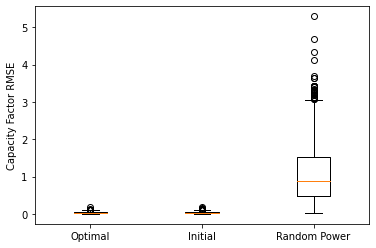

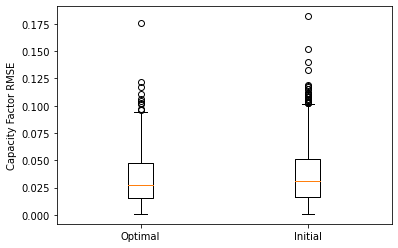

In [32]:
pvPlants = get_PVPlants2()

x0  = [10000.0] + getInit(pvPlants)[0]
resInit = optimization(x0, dfProduction["PV_Ante"], pvPlants, dfWeather, angles)

x1 = [1.09007569e+04, 4.00000000e+01, 4.00000000e+01, 4.00000000e+01,
 6.00000000e+01, 6.00000000e+01, 6.00000000e+01, 4.17726585e-08,
 2.00000000e+01, 2.00000000e+01]
resOpti = optimization(x1, dfProduction["PV_Ante"], pvPlants, dfWeather, angles)
#plt.plot(resOpti.groupby(resOpti.index.hour).mean())
x2 = np.random.rand(len(pvPlants))
x2 = x2 / np.sum(x2) * 10000
print(x2)
resMin = optimization2(x2, dfProduction["PV_Ante"], pvPlants, dfWeather, angles)

squaredErrInit = pd.Series( resInit.values ** 2, index =resInit.index)
squaredErrOpti = pd.Series( resOpti.values ** 2, index =resOpti.index)
squaredErrMinVals = pd.Series( resMin.values ** 2, index =resMin.index)
cerr = pd.concat([ np.sqrt(squaredErrOpti.groupby(resOpti.index.date).mean())/ x1[0],
    np.sqrt(squaredErrInit.groupby(resInit.index.date).mean())/ x0[0],
    np.sqrt(squaredErrMinVals.groupby(resMin.index.date).mean())/ x2[0]], axis=1)
cerr.rename({0: "OptimalSolution", 1: "InitialSolution", 2: "Random"}, axis = 1, inplace = True)
print(np.sqrt(np.mean(squaredErrOpti)))
print(dfProduction.std())
fig, ax = plt.subplots()
ax.boxplot(cerr)
ax.set_xticklabels(["Optimal", "Initial", "Random Power"])
ax.set_ylabel("Capacity Factor RMSE")
fig, ax = plt.subplots()
ax.boxplot(cerr.iloc[:,:2])
ax.set_xticklabels(["Optimal", "Initial"])
ax.set_ylabel("Capacity Factor RMSE")

## Plot der Leistungsverteilungen nach Optimierung der Leistungsverteilung im Verhältnis zu realen pro NUTS2 Zone

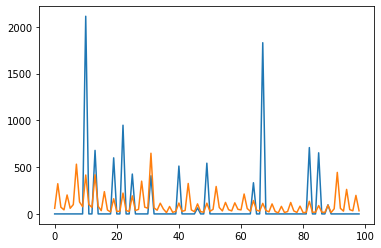

In [ ]:
xOpti =[9.80452985e-09, 3.35415149e-07, 6.65238870e-08, 3.46149106e-09, 8.42715009e-08, 2.19119287e-08, 4.41115243e-09, 9.79787114e-08, 2.04065076e-08, 1.85858791e-07, 2.11319429e+03, 1.89783674e-05, 8.70258701e-08, 6.79023149e+02, 6.21194603e-06, 2.83243302e-09, 7.66285898e-07, 6.50855467e-08, 3.33197633e-08, 5.99475839e+02, 1.17601154e-07, 3.78930687e-08, 9.48303397e+02, 7.45809653e-07, 2.21209138e-08, 4.26154223e+02, 2.04225039e-07, 5.18573363e-13, 5.89979175e-09, 4.30036011e-10, 4.77692870e-08, 4.07695961e+02, 1.88832662e-06, 5.23749668e-10, 2.36531399e-08, 8.31034457e-09, 2.90828465e-08, 9.67517971e-08, 6.05070068e-07, 2.29555888e-08, 5.11546521e+02, 4.10268092e-07, 2.47154037e-09, 3.46125417e-07, 2.99246148e-08, 9.84475406e-08, 6.40987908e+01, 1.84082609e-05, 4.94884510e-10, 5.42356544e+02, 2.67131487e-07, 6.42569533e-09, 5.62528610e-07, 6.01497894e-08, 4.28810621e-09, 1.22994551e-07, 2.79182139e-08, 2.47623621e-09, 5.30755433e-08, 1.51746254e-08, 3.45480956e-08, 2.84464058e-06, 3.26632879e-07, 8.20140091e-08, 3.33264112e+02, 7.76690546e-06, 1.83931689e-08, 1.83033891e+03, 8.01772370e-07, 3.18120806e-12, 2.71720489e-08, 3.69449193e-09, 2.61191150e-10, 1.43322837e-08, 1.59604641e-09, 2.34177005e-10, 2.31323265e-09, 1.62042250e-12, 2.63926063e-11, 5.45365245e-09, 5.41333210e-10, 9.80303086e-09, 7.09188342e+02, 1.51166453e-06, 4.01108148e-11, 6.53363542e+02, 1.50841387e-06, 9.56348490e-10, 9.67148688e+01, 6.49105324e-07, 3.61776300e-09, 8.78850405e-07, 6.16609103e-08, 1.34896683e-10, 1.84163378e-08, 2.86218408e-09, 9.90457624e-10, 6.19555056e-07, 4.34017369e-08]
xInit = pvPlants["PowerMWRelative"].values * 10000

plt.plot(xOpti)
plt.plot(xInit)